In [3]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# specify the data file path
fdirdata = "/mnt/c/Users/firma/Documents/Projects/Git/idcovid19/data"
fdata = os.path.join(fdirdata, "data.csv")
frecdec = os.path.join(fdirdata, "recdec.csv")

In [27]:
# load the data
# columns are: (days#, new case, new recovery, new death, cum case, cum recovery, cum death)
data = np.loadtxt(fdata, skiprows=1, delimiter=",", usecols=list(range(1,8))).astype(np.int)
day_no = data[:,0]
cum_case = data[:,4]
cum_rec = data[:,5]
cum_dec = data[:,6]
with open(frecdec, "r") as f:
    rec_no = [int(d) for d in f.readline().split()[1].split(",")]
    dec_no = [int(d) for d in f.readline().split()[1].split(",")]
print(rec_no)
print(dec_no)
print(data[28:34])

[1, 2, 3, 6, 7, 8, 9, 13]
[25, 35, 36, 39, 50, 71, 72, 74, 87, 99, 109, 113, 116, 117, 118, 384]
[[ 28  35   2   3  67   5   4]
 [ 29  27   3   1  94   8   5]
 [ 30  21   0   0 115   8   5]
 [ 31  17   0   0 132   8   5]
 [ 32  38   1   2 170   9   7]
 [ 33  55   2  12 225  11  19]]


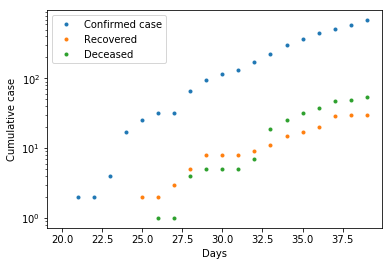

In [42]:
# plot the cumulative recovered and deceased
plot_offset = 20
plt.plot(day_no[plot_offset:], cum_case[plot_offset:], 'C0.', label="Confirmed case")
plt.plot(day_no[plot_offset:], cum_rec[plot_offset:], 'C1.', label="Recovered")
plt.plot(day_no[plot_offset:], cum_dec[plot_offset:], 'C2.', label="Deceased")
plt.gca().set_yscale("log")
plt.xlabel("Days")
plt.ylabel("Cumulative case")
plt.legend()

Recovery period:
* median: 5.000e+00
* 68 CI: (4.000e+00 to 7.640e+00)
* 95 CI: (4.000e+00 to 9.650e+00)
Deceased period:
* median: 1.100e+01
* 68 CI: (9.000e+00 to 1.200e+01)
* 95 CI: (5.875e+00 to 1.200e+01)


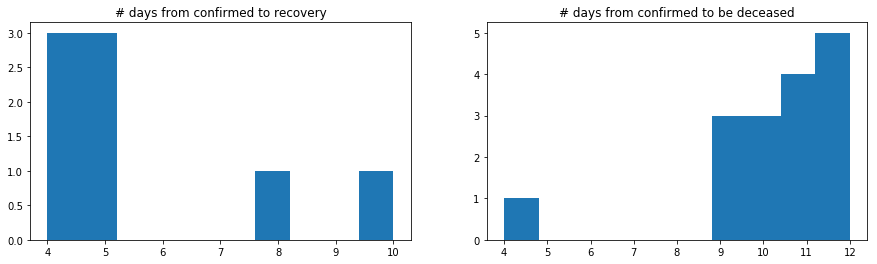

In [26]:
# estimate the recovery and deceased time from the data (it is the rec/dec from confirmed)
# because the lack of the data, we assume the patient recovered/deceased on the sequential order
#  (e.g. patient 6 was recovered before patient 7, 8, 9, etc)
def get_day(cum_data, patient_no):
    day = cum_data.shape[0] - np.sum(np.expand_dims(cum_data, axis=1) >= np.expand_dims(patient_no, axis=0), axis=0)
    return day

confirmed_day_rec = get_day(cum_case, rec_no)
confirmed_day_dec = get_day(cum_case, dec_no)
recovery_day = get_day(cum_rec, rec_no)
deceased_day = get_day(cum_rec, dec_no)
recovery_period = recovery_day - confirmed_day_rec
deceased_period = deceased_day - confirmed_day_dec

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.hist(recovery_period)
plt.title("# days from confirmed to recovery")
plt.subplot(1,2,2)
plt.hist(deceased_period)
plt.title("# days from confirmed to be deceased")

# print the statistics
def print_stats(samples, name):
    print("%s:" % name)
    print("* median: %.3e" % np.median(samples))
    print("* 68 CI: (%.3e to %.3e)" % (np.percentile(samples, 50-34), np.percentile(samples, 50+34)))
    print("* 95 CI: (%.3e to %.3e)" % (np.percentile(samples, 2.5), np.percentile(samples, 97.5)))
          
print_stats(recovery_period, "Recovery period")
print_stats(deceased_period, "Deceased period")

# Data fitting

### Fitting gradient in log-scale

Exponent factor: 1.761e-01
Case doubling every: 3.9 days


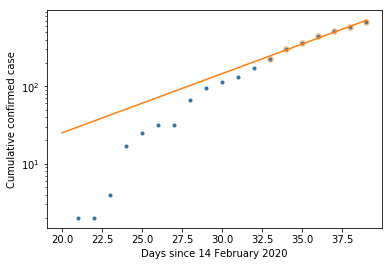

In [57]:
# fit the cumulative case to get the gradient in the logscale
day_offset_grad = 33

xgrad = day_no[day_offset_grad:]
ygrad = cum_case[day_offset_grad:]
gradient, offset = np.polyfit(xgrad, np.log(ygrad), 1)
print("Exponent factor: %.3e" % gradient)
print("Case doubling every: %.1f days" % (np.log(2)/gradient))

plt.plot(day_no[plot_offset:], cum_case[plot_offset:], 'C0.')
plt.plot(xgrad, ygrad, 'C1o', alpha=0.3)
plt.plot(day_no[plot_offset:], np.exp(gradient*day_no[plot_offset:] + offset), 'C1-')
plt.xlabel("Days since 14 February 2020")
plt.ylabel("Cumulative confirmed case")
plt.gca().set_yscale("log")

### Fitting case ratio

Deceased / recovered ratio: 1.757e+00
Deceased / confirmed case ratio: 8.528e-02


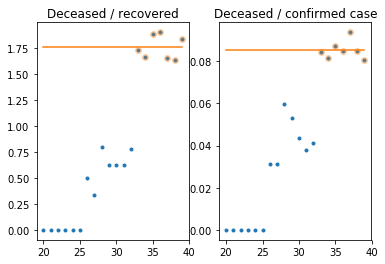

In [60]:
# find the ratio between deceased/recovered and deceased/confirmed
day_offset_ratio = 33

dec_by_rec = cum_dec / (cum_rec + 1e-12) # safeguarding from /0
dec_by_conf = cum_dec / (cum_case + 1e-12)
ndec_by_rec = np.mean(dec_by_rec[day_offset_ratio:])
ndec_by_conf = np.mean(dec_by_conf[day_offset_ratio:])
print("Deceased / recovered ratio: %.3e" % ndec_by_rec)
print("Deceased / confirmed case ratio: %.3e" % ndec_by_conf)

plt.subplot(1,2,1)
plt.plot(day_no[plot_offset:], dec_by_rec[plot_offset:], 'C0.')
plt.plot(day_no[day_offset_ratio:], dec_by_rec[day_offset_ratio:], 'C1o', alpha=0.3)
plt.plot(day_no[plot_offset:], day_no[plot_offset:]*0+ndec_by_rec, 'C1-')
plt.title("Deceased / recovered")
plt.subplot(1,2,2)
plt.plot(day_no[plot_offset:], dec_by_conf[plot_offset:], 'C0.')
plt.plot(day_no[day_offset_ratio:], dec_by_conf[day_offset_ratio:], 'C1o', alpha=0.3)
plt.plot(day_no[plot_offset:], day_no[plot_offset:]*0+ndec_by_conf, 'C1-')
plt.title("Deceased / confirmed case")
plt.show()

# Parameters calculation

In [138]:
# collect the variable inferred directly from the data
# I do not include the recovery period in the equation because
#  almost all recovered patients are patients at the beginning,
#  so the recovery period is severely underestimated
K = gradient
ndr = ndec_by_rec
ndc = ndec_by_conf
td = np.median(deceased_period) / np.log(2)

# survival rate
def get_surv_rate(K, ndr, ndc, td):
    return 1. - ndc * (K*td+1)

# recovery period
def get_rec_period(K, ndr, ndc, td):
    surv_rate = get_surv_rate(K, ndr, ndc, td)
    tr = (ndr * surv_rate / (1-surv_rate) * (K*td+1) - 1) / K
    return tr

surv_rate = get_surv_rate(K, ndr, ndc, td)
tr = get_rec_period(K, ndr, ndc, td)
print("Survival rate: %.2f" % surv_rate)
print("Recovery period: %.1f days" % tr)
print("Median recovery period: %.1f days" % (tr*np.log(2)))

Survival rate: 0.68
Recovery period: 73.5 days
Median recovery period: 50.9 days


### Variation as a function of deceased period

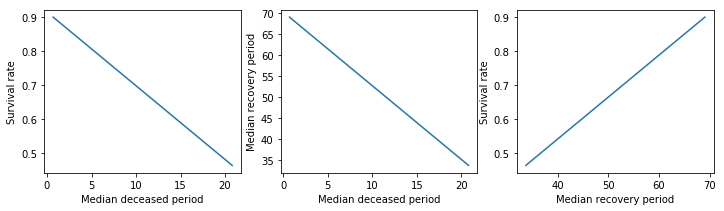

In [129]:
tds = np.linspace(1, 30, 100)
trs = get_rec_period(K, ndr, ndc, tds)
surv_rates = get_surv_rate(K, ndr, ndc, tds)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(tds * np.log(2), surv_rates)
plt.ylabel("Survival rate")
plt.xlabel("Median deceased period")
plt.subplot(1,3,2)
plt.plot(tds * np.log(2), trs * np.log(2))
plt.ylabel("Median recovery period")
plt.xlabel("Median deceased period")
plt.subplot(1,3,3)
plt.plot(trs*np.log(2), surv_rates)
plt.xlabel("Median recovery period")
_ = plt.ylabel("Survival rate")

# Simulation

In [ ]:
def jac()